<a href="https://colab.research.google.com/github/skyjadel/chang-s_titanic/blob/main/Titanic_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')

In [2]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


先移除 Name，Ticket，Cabin<br>
Name 比較難以量化，可能可以找關聯性，但較為複雜，先剔除，同理移除ticket<br>
Cabin 缺失值太多，移除


In [3]:
df = df[list(set(df.columns).difference(['Ticket','Name','Cabin']))]
df

,Parch,Age,Fare,PassengerId,SibSp,Survived,Embarked,Sex,Pclass
0,0,22.0,7.2500,1,1,0,S,male,3
1,0,38.0,71.2833,2,1,1,C,female,1
2,0,26.0,7.9250,3,0,1,S,female,3
3,0,35.0,53.1000,4,1,1,S,female,1
4,0,35.0,8.0500,5,0,0,S,male,3
...,...,...,...,...,...,...,...,...,...
886,0,27.0,13.0000,887,0,0,S,male,2
887,0,19.0,30.0000,888,0,1,S,female,1
888,2,NaN,23.4500,889,1,0,S,female,3
889,0,26.0,30.0000,890,0,1,C,male,1


# 資料前處理

## 區分 Training Set 與 Testing Set

In [4]:
train_df, test_df = train_test_split(df, test_size=0.25,
                    #random_state=338421,
                    )
print(f'{len(train_df)} rows in training set.')
print(f'{len(test_df)} rows in testing set.')

668 rows in training set.
223 rows in testing set.


## 補缺失值

從上次的EDA我們知道，有缺失值的欄位有 Age 和 Embarked，Age將補上training set 的平均值，Embarked將補上trainin set 的最多分類。


---

20240510 12:40 <br>
因為發現不同艙等的年齡分布有差別，而三等艙的旅客年齡缺失的機率又比較大，所以改填各艙等的平均年齡。

In [5]:
# 找出哪個港口上船的人最多
grouped = train_df.groupby('Embarked')
harbor_counts = {g[0]:len(g[1]) for g in grouped}

max_count = 0
for k, v in harbor_counts.items():
  if v > max_count:
    max_count = v
    major_embarked_harbor = k

In [6]:
# Training Set 的年齡平均值
#mean_age = train_df['Age'].mean()
mean_age = {i: train_df[train_df['Pclass']==i]['Age'].mean() for i in range(1,4)}

In [7]:
def fill_nan(df, age_value=mean_age, embarked_value=major_embarked_harbor):
  df = df.fillna({'Embarked':embarked_value})


  if type(age_value) == dict:
    age_is_na = df['Age'].isna()
    for i in df.index:
      if age_is_na[i]:
        df.loc[i, 'Age'] = mean_age[df.loc[i, 'Pclass']]
  else:
    df = df.fillna({'Age':age_value})

  return df

## Labeling

Sex 欄位改稱 Sex_female 欄位 <br>
Embarked 使用onehot <br>
註：這邊曾經嘗試不要刪除'Sex_male'，發現沒有任何改善，因次不採用這個更動

In [8]:
def labeling(df, remove_sex_male=True):
  df = pd.concat([df, pd.get_dummies(df[['Sex', 'Embarked']])], axis=1)
  if remove_sex_male:
    df.drop(['Sex', 'Embarked', 'Sex_male'], axis=1, inplace=True)
  else:
    df.drop(['Sex', 'Embarked'], axis=1, inplace=True)
  return df

## 添加特徵

前面發現單人登船者生還率較低，因此嘗試加入是否為單人特徵
(測試結果發現沒有比較好，停用)

In [9]:
def single(df):
  df['Single'] = 0
  for i in df.index:
    if sum(df.loc[i][['SibSp', 'Parch']])==0:
      df.loc[i, 'Single'] = 1
  return df

前面發現15歲以下生還率較高，因此嘗試加入是否為15歲以下特徵

In [10]:
def young(df):
  df['Young'] = 0
  for i in df.index:
    if df.loc[i]['Age']<=15:
      df.loc[i, 'Young'] = 1
  return df

前面發現60歲以下生還率較低，嘗試加入是否為60歲以下特徵(測試結果發現沒有比較好，停用)

In [11]:
def old(df):
  df['Old'] = 0
  for i in df.index:
    if df.loc[i]['Age']>60:
      df.loc[i, 'Old'] = 1
  return df

前面發現在票價低於100元時，票價越高生還率越高，加入票價binning(測試結果發現沒有比較好，停用)

In [12]:
def fare_binning(df, cuts=[25, 50, 75, 100]):
  df['Fare_Bin'] = 0
  for i in df.index:
    this_fb = 0
    this_fare = df.loc[i,'Fare']
    for c in cuts:
      if this_fare > c:
        this_fb += 1
      else:
        df.loc[i, 'Fare_Bin'] = this_fb
        break
  #df.drop('Fare', axis=1, inplace=True)
  return df

## 前處理函式

In [13]:
def preprocess(df):
  df = labeling(fill_nan(df))
  #df = single(df)
  df = young(df)
  #df = old(df)
  #df = fare_binning(df)
  return df

In [14]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [15]:
train_df

,Parch,Age,Fare,PassengerId,SibSp,Survived,Pclass,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Young
509,0,26.000000,56.4958,510,0,1,3,False,False,False,True,0
822,0,38.000000,0.0000,823,0,0,1,False,False,False,True,0
211,0,35.000000,21.0000,212,0,1,2,True,False,False,True,0
801,1,31.000000,26.2500,802,1,1,2,True,False,False,True,0
779,1,43.000000,211.3375,780,0,1,1,True,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...
434,0,50.000000,55.9000,435,1,0,1,False,False,False,True,0
313,0,28.000000,7.8958,314,0,0,3,False,False,False,True,0
780,0,13.000000,7.2292,781,0,1,3,True,True,False,False,1
573,0,24.745985,7.7500,574,0,1,3,True,False,True,False,0


# 訓練

In [16]:
columns_X = list(set(train_df.columns) - {'Survived', 'PassengerId'})
columns_y = ['Survived']

train_X = train_df[columns_X]
train_y = train_df[columns_y]
test_X = test_df[columns_X]
test_y = test_df[columns_y]

In [17]:
def model_training_and_evaluation(model, train_X, train_y, test_X, test_y):
  scores = cross_val_score(model, train_X, train_y.values.ravel(),cv=5,scoring='accuracy')
  cv_acc = np.mean(scores)
  print(f'平均準確率{np.mean(scores):.4f}')

  H = model.fit(np.array(train_X), np.array(train_y).reshape(-1))

  pred_y = model.predict(np.array(train_X))
  true_y = yt = np.array(train_y).reshape(-1)
  acc_samples = sum(true_y * pred_y) + sum((1-true_y)*(1-pred_y))
  train_acc = acc_samples/len(train_df)
  print(f'Accuracy for training set is {train_acc:.4f} ({acc_samples}/{len(train_df)})')

  pred_y = model.predict(np.array(test_X))
  true_y = yt = np.array(test_y).reshape(-1)
  acc_samples = sum(true_y * pred_y) + sum((1-true_y)*(1-pred_y))
  test_acc = acc_samples/len(test_df)
  print(f'Accuracy for testing set is {test_acc:.4f} ({acc_samples}/{len(test_df)})')

  return model, cv_acc, train_acc, test_acc

In [18]:
model_records = {}

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


this_model = LogisticRegression(random_state=0, max_iter=3000)
model_records['Logistic Regression'] = model_training_and_evaluation(this_model, train_X, train_y, test_X, test_y)

平均準確率0.8085
Accuracy for training set is 0.8114 (542/668)
Accuracy for testing set is 0.7937 (177/223)


# 結論

進行特徵工程之前的 accuracy 為  
cross validation: 0.7936, train-test 8:2 split: 0.7989  
目前嘗試過的特徵工程：
1. 年齡缺失值改填艙等平均年齡，acc: 0.8034, 0.8101 (採納)  
2. 加入是否為單身的特徵，acc:0.8076, 0.7989 (不採納)  
3. 加入是否小於15歲的特徵，acc: 0.8062, 0.8156 (採納)(目前最佳)  
4. 性別使用onehot encoding而非labelencoding，acc:  0.8034, 0.8156 (不採納)  
5. 加入是否大於60歲的特徵，acc: 0.8062, 0.8156 (不採納)  
6. 加入票價裝箱，acc: 0.8048, 0.8101 (不採納)

# Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
this_model = DecisionTreeClassifier(max_depth=3)
model_records['Decision Tree'] = model_training_and_evaluation(this_model, train_X, train_y, test_X, test_y)

平均準確率0.7965
Accuracy for training set is 0.8189 (547/668)
Accuracy for testing set is 0.8027 (179/223)


## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
this_model = RandomForestClassifier(max_depth=4, n_estimators=100)
model_records['Random Forest'] = model_training_and_evaluation(this_model, train_X, train_y, test_X, test_y)

平均準確率0.8280
Accuracy for training set is 0.8488 (567/668)
Accuracy for testing set is 0.8117 (181/223)


## XGBoost

In [22]:
import xgboost as xgb
this_model = xgb.XGBClassifier(max_depth=2, n_estimators=15)
model_records['XGBoost'] = model_training_and_evaluation(this_model, train_X, train_y, test_X, test_y)


平均準確率0.8175
Accuracy for training set is 0.8428 (563/668)
Accuracy for testing set is 0.8027 (179/223)


## SVM with Linear Kernal

In [23]:
from sklearn import svm
this_model = svm.LinearSVC(max_iter=30000)
model_records['SVM_Linear'] = model_training_and_evaluation(this_model, train_X, train_y, test_X, test_y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


平均準確率0.8100
Accuracy for training set is 0.8129 (543/668)
Accuracy for testing set is 0.8117 (181/223)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## SVM with RBF kernel

In [24]:
from sklearn.svm import SVC
this_model = SVC(kernel="rbf", C=10, max_iter=30000)
model_records['SVM_RBF'] = model_training_and_evaluation(this_model, train_X, train_y, test_X, test_y)

平均準確率0.7051
Accuracy for training set is 0.7246 (484/668)
Accuracy for testing set is 0.7399 (165/223)


## Neural Network

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
import torch.optim as optim
from tqdm import tqdm

In [26]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
print(device.type)

cuda


In [27]:
class SimpleNN(nn.Module):
  def __init__(self, input_f, output_f, feature_counts, dropout_factor):
    super(SimpleNN, self).__init__()
    self.feature_counts = feature_counts
    self.dropout_factor = dropout_factor
    self.BN0 = nn.BatchNorm1d(input_f)
    self.blocks = nn.ModuleList()
    for i, f in enumerate(feature_counts):
      out_f = f
      if i == 0:
        in_f = input_f
      else:
        in_f = feature_counts[i-1]

      self.blocks.append(self.fnn_block(in_f, out_f))
    self.output_layer = nn.Linear(feature_counts[-1], output_f)
    self.sigmoid = nn.Sigmoid()


  def fnn_block(self, in_f, out_f, dropout=True, activation=True):
    layers = []
    layers.append(nn.Linear(in_f, out_f))
    layers.append(nn.BatchNorm1d(out_f))
    if activation:
      layers.append(nn.ReLU())
    if dropout:
      layers.append(nn.Dropout(p=self.dropout_factor))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.BN0(x)
    for block in self.blocks:
      x = block(x)
    x = self.output_layer(x)
    out = self.sigmoid(x)
    return out

In [28]:
X_tv = np.array(train_X)
X_tv[np.where(X_tv==True)] = 1
X_tv[np.where(X_tv==False)] = 0
X_tv = X_tv.astype(np.float32)

X_test = np.array(test_X)
X_test[np.where(X_test==True)] = 1
X_test[np.where(X_test==False)] = 0
X_test = X_test.astype(np.float32)

y_tv = np.array(train_y).astype(np.float32)
y_test = np.array(test_y).astype(np.float32)

In [29]:
X_tv_tensor = torch.tensor(X_tv, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_tv_tensor = torch.tensor(y_tv, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [30]:
TV_dataset = TensorDataset(X_tv_tensor.to(device), y_tv_tensor.to(device))
Test_dataset = TensorDataset(X_test_tensor.to(device), y_test_tensor.to(device))

In [31]:
def accuracy(y_pred, y_truth):
  y_pred[y_pred<0.5] = 0
  y_pred[y_pred>=0.5] = 1
  acc = ((y_pred * y_truth).sum().item() + ((1 - y_pred) * (1 - y_truth)).sum().item()) / y_pred.size()[0]
  return acc

In [32]:
feature_counts = [80, 300, 300, 200, 100, 60]
lr = 1e-3
num_epochs = 100
L2_factor = 5e-5
dropout_factor = 0.4

In [33]:
KF = KFold(5, shuffle=True)
histories = {}
for fold, (train_idx, val_idx) in enumerate(KF.split(X_tv)):
  train_subset = Subset(TV_dataset, train_idx)
  val_subset = Subset(TV_dataset, val_idx)

  DL_train = DataLoader(train_subset, batch_size=32, shuffle=True)
  DL_val = DataLoader(val_subset, batch_size=32, shuffle=False)

  model = SimpleNN(input_f = X_tv.shape[1], output_f=1, feature_counts=feature_counts, dropout_factor=dropout_factor).to(device)

  previous_lr = lr
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=L2_factor)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=10**(-0.5), patience=10)
  criterion = nn.BCELoss()
  history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

  print(f'Fold {fold} started!')
  for epoch in tqdm(range(num_epochs)):
    model.train()
    total_train_loss = 0
    total_samples = 0
    total_train_acc = 0
    for this_X, this_y in DL_train:
      optimizer.zero_grad()
      y_pred = model(this_X)
      loss_train = criterion(y_pred, this_y)
      loss_train.backward()
      optimizer.step()

      this_batch_size = this_X.size()[0]
      total_train_loss += loss_train * this_batch_size
      total_train_acc += accuracy(y_pred, this_y) * this_batch_size
      total_samples += this_batch_size

    mean_loss_train = (total_train_loss / total_samples).item()
    mean_acc_train = total_train_acc / total_samples
    history['train_loss'].append(mean_loss_train)
    history['train_acc'].append(mean_acc_train)

    model.eval()
    total_val_loss = 0
    total_samples = 0
    total_val_acc = 0
    with torch.no_grad():
      for this_X, this_y in DL_val:
        y_pred = model(this_X)

        this_batch_size = this_X.size()[0]
        this_loss = criterion(y_pred, this_y)
        total_val_loss += this_loss * this_batch_size
        total_val_acc += accuracy(y_pred, this_y) * this_batch_size
        total_samples += this_batch_size

    mean_loss_val = (total_val_loss / total_samples).item()
    mean_acc_val = total_val_acc / total_samples
    history['val_loss'].append(mean_loss_val)
    history['val_acc'].append(mean_acc_val)
    scheduler.step(mean_loss_val)

    current_lr = optimizer.param_groups[0]['lr']
    if not current_lr == previous_lr:
      if current_lr < 1e-6:
          #print(f'Learning rate is very small, terimnate training.')
          break
      #print(f"Learning rate changed from {previous_lr} to {current_lr}")
      previous_lr = current_lr
  histories[fold] = history
  model.eval()

mean_cv_acc = np.mean([histories[f]['val_acc'][-1] for f in range(5)])
print(' ')
print(f'平均準確率{mean_cv_acc:.4f}')

Fold 0 started!


 97%|█████████▋| 97/100 [00:18<00:00,  5.38it/s]


Fold 1 started!


100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


Fold 2 started!


 83%|████████▎ | 83/100 [00:07<00:01, 11.17it/s]


Fold 3 started!


 99%|█████████▉| 99/100 [00:09<00:00, 10.05it/s]


Fold 4 started!


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]

 
平均準確率0.8309


In [34]:
DL_train = DataLoader(TV_dataset, batch_size=32, shuffle=True)
DL_val = DataLoader(Test_dataset, batch_size=32, shuffle=False)

model = SimpleNN(input_f = X_tv.shape[1], output_f=1, feature_counts=feature_counts, dropout_factor=dropout_factor).to(device)

previous_lr = lr
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=L2_factor)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=10**(-0.5), patience=10)
criterion = nn.BCELoss()
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(num_epochs):
  model.train()
  total_train_loss = 0
  total_train_acc = 0
  total_samples = 0
  for this_X, this_y in DL_train:
    optimizer.zero_grad()
    y_pred = model(this_X)
    loss_train = criterion(y_pred, this_y)
    loss_train.backward()
    optimizer.step()

    this_batch_size = this_X.size()[0]
    total_train_loss += loss_train * this_batch_size
    total_train_acc += accuracy(y_pred, this_y) * this_batch_size
    total_samples += this_batch_size

  mean_loss_train = (total_train_loss / total_samples).item()
  mean_acc_train = total_train_acc / total_samples
  history['train_loss'].append(mean_loss_train)
  history['train_acc'].append(mean_acc_train)

  model.eval()
  total_val_loss = 0
  total_val_acc = 0
  total_samples = 0
  with torch.no_grad():
    for this_X, this_y in DL_val:
      y_pred = model(this_X)

      this_batch_size = this_X.size()[0]
      this_loss = criterion(y_pred, this_y)
      total_val_loss += this_loss * this_batch_size
      total_val_acc += accuracy(y_pred, this_y) * this_batch_size
      total_samples += this_batch_size

  mean_loss_val = (total_val_loss / total_samples).item()
  mean_acc_val = total_val_acc / total_samples
  history['val_loss'].append(mean_loss_val)
  history['val_acc'].append(mean_acc_val)
  scheduler.step(mean_loss_val)

  this_msg = f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {mean_loss_train:.4f}, Validation Loss: {mean_loss_val:.4f}, '
  this_msg += f'Training Acc: {mean_acc_train:.4f}, Validation Acc: {mean_acc_val:.4f}'
  print(this_msg)

  current_lr = optimizer.param_groups[0]['lr']
  if not current_lr == previous_lr:
    if current_lr < 1e-6:
        print(f'Learning rate is very small, terimnate training.')
        break
    print(f"Learning rate changed from {previous_lr} to {current_lr}")
    previous_lr = current_lr

final_train_acc = history['train_acc'][-1]
final_test_acc = history['val_acc'][-1]

Epoch [1/100], Training Loss: 0.6782, Validation Loss: 0.6065, Training Acc: 0.5913, Validation Acc: 0.6637
Epoch [2/100], Training Loss: 0.5930, Validation Loss: 0.4904, Training Acc: 0.7006, Validation Acc: 0.7803
Epoch [3/100], Training Loss: 0.5221, Validation Loss: 0.4386, Training Acc: 0.7470, Validation Acc: 0.8027
Epoch [4/100], Training Loss: 0.5006, Validation Loss: 0.4286, Training Acc: 0.7934, Validation Acc: 0.8072
Epoch [5/100], Training Loss: 0.5011, Validation Loss: 0.4236, Training Acc: 0.7754, Validation Acc: 0.8206
Epoch [6/100], Training Loss: 0.4857, Validation Loss: 0.4280, Training Acc: 0.7814, Validation Acc: 0.8341
Epoch [7/100], Training Loss: 0.4729, Validation Loss: 0.4263, Training Acc: 0.8009, Validation Acc: 0.8206
Epoch [8/100], Training Loss: 0.4698, Validation Loss: 0.4313, Training Acc: 0.7904, Validation Acc: 0.8296
Epoch [9/100], Training Loss: 0.4754, Validation Loss: 0.4301, Training Acc: 0.7859, Validation Acc: 0.8117
Epoch [10/100], Training Los

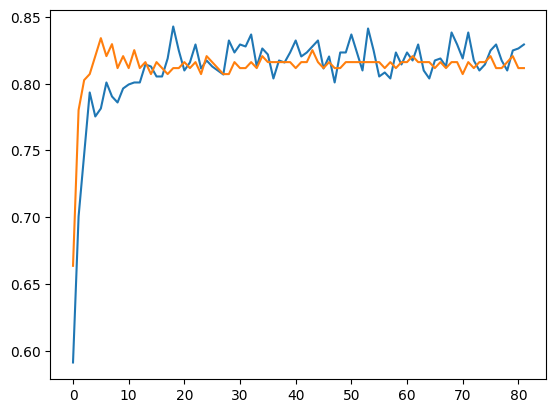

In [35]:
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])

In [36]:
model_records['Neural Network'] = (model, mean_cv_acc, final_train_acc, final_test_acc)

## List of outcomes of models

In [37]:
acc_dict = {'Model_Type':[], 'CV_acc':[], 'Train_acc':[], 'Test_acc':[]}
for key, val in model_records.items():
  acc_dict['Model_Type'].append(key)
  acc_dict['CV_acc'].append(val[1])
  acc_dict['Train_acc'].append(val[2])
  acc_dict['Test_acc'].append(val[3])

In [38]:
acc_df = pd.DataFrame(acc_dict)
acc_df

,Model_Type,CV_acc,Train_acc,Test_acc
0,Logistic Regression,0.808461,0.811377,0.793722
1,Decision Tree,0.796476,0.818862,0.802691
2,Random Forest,0.827965,0.848802,0.811659
3,XGBoost,0.817495,0.842814,0.802691
4,SVM_Linear,0.809999,0.812874,0.811659
5,SVM_RBF,0.705095,0.724551,0.739910
6,Neural Network,0.830917,0.829341,0.811659


## Ensemble Learning

In [39]:
model_list = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'XGBoost',
    #'SVM_Linear',
    #'SVM_RBF',
    'Neural Network'
    ]
# model_list = ['Decision Tree',
#               'Random Forest',
#               'XGBoost']

In [40]:
Y_preds = []
models = {}
for this_model_type in model_list:
  this_model = model_records[this_model_type][0]
  models[this_model_type] = this_model
  if this_model_type == 'Neural Network':
    Y_pred = this_model(torch.Tensor(np.array(test_X).astype(np.float32)).to(device)).cpu().detach().numpy().reshape(-1,)
    Y_pred[np.where(Y_pred<0.5)] = 0
    Y_pred[np.where(Y_pred>=0.5)] = 1
    Y_preds.append(Y_pred)
  else:
    Y_preds.append(this_model.predict(test_X))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [41]:
Y_preds = np.array(Y_preds)
mean_Y_pred = np.mean(Y_preds, axis=0)

mean_Y_pred[np.where(mean_Y_pred>0.5)] = 1
mean_Y_pred[np.where(mean_Y_pred<0.5)] = 0

Y_true = np.array(test_y).reshape(-1)
ensemble_acc = (np.sum(Y_true * mean_Y_pred) + np.sum((1-Y_true) * (1-mean_Y_pred)))/Y_true.shape[0]
print(f'The ensemble acc: {ensemble_acc:.4f}')

The ensemble acc: 0.8161


In [42]:
acc_df.loc[acc_df.shape[0]] = ['Ensemble', None, None, ensemble_acc]
acc_df

,Model_Type,CV_acc,Train_acc,Test_acc
0,Logistic Regression,0.808461,0.811377,0.793722
1,Decision Tree,0.796476,0.818862,0.802691
2,Random Forest,0.827965,0.848802,0.811659
3,XGBoost,0.817495,0.842814,0.802691
4,SVM_Linear,0.809999,0.812874,0.811659
5,SVM_RBF,0.705095,0.724551,0.739910
6,Neural Network,0.830917,0.829341,0.811659
7,Ensemble,NaN,NaN,0.816143
